# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
from sklearn import preprocessing
import pandas as pd

Load the `cardiac_ml_tools` module.

In [2]:
%run cardiac_ml_tools.py

## Load the dataset

In [3]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='dataset/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR): # os.listdir gets all the folders in a directory
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


# numbers = [0,872,2613,4012,6093,7833,16540]
# print(numbers)
# for i in range(0, len(numbers)):
#     numbers[i] = int(numbers[i]/2)  
# print(numbers)

# 0, 436, 1306, 2006, 3046, 3916, 8270
# need to divide all these by 2

Number of file pairs: 16117
Example of file pair:
dataset/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
dataset/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy


## Normalize ECG Data

In [4]:
def normalize_ecg(ecg):
    normalized_ecg = np.zeros_like(ecg)
    # print(normalized_ecg)
    # print(ecg)

    for i in range(ecg.shape[0]):
        lead_min = np.min(ecg[i])
        lead_max = np.max(ecg[i])
        lead_range = lead_max - lead_min

        # print(f'lead_min: {lead_min} lead_max: {lead_max} lead_range: {lead_range}')
        
        if lead_range != 0:
            normalized_ecg[i] = (ecg[i] - lead_min) / lead_range
        else:
            normalized_ecg[i] = ecg[i] - lead_min  # If the lead is constant, just center it at 0
    
    # normalized_ecg = preprocessing.normalize(ecg)
    # normalized_ecg = preprocessing.MinMaxScaler(ecg)
    
    return normalized_ecg

testDataset = np.load(file_pairs[0][0])
normalize_ecg(testDataset)
print('done')

done


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) 
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](../figures/data_generation.png)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\ 
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

In [5]:
def graph_12ecg(ecg, case, row=3, column=4):
    num_timesteps = 500
    titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

    print('Case {} : {}'.format(case, file_pairs[case][0]))
    
    plt.figure(figsize=(10, 7))
    
    for i in range(ecg.shape[1]):
        plt.subplot(row, column, reorder[i + 1])
        plt.plot(ecg[0:num_timesteps,i],'r')
        plt.title(titles[i])
        plt.grid(visible=True, which='major', color='#666666', linestyle='-')
        plt.minorticks_on()
        plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        plt.xlabel('msec')
        plt.ylabel('mV')
        
    plt.tight_layout()
    plt.show()
    # plt.savefig('foo.png', bbox_inches='tight')
    plt.close()

Case 8275 : dataset/intracardiac_dataset/data_hearts_dd_0p2_geo_inn/pECGData_hearts_dd_0p2_geo_inn_innerindex.4.volunteer.v12.npy


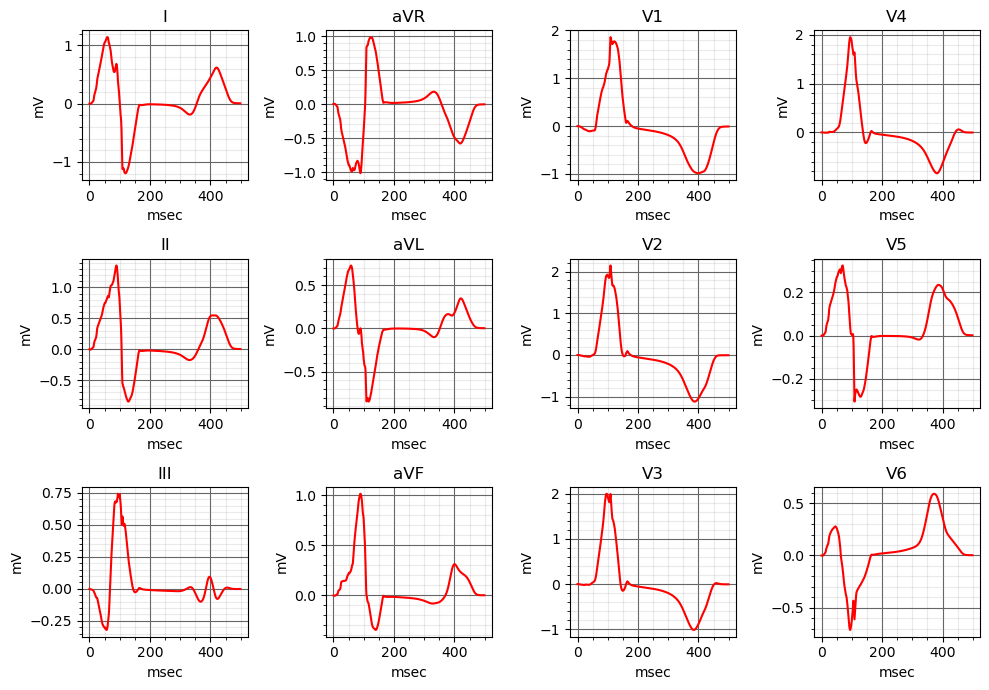

In [6]:
case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

graph_12ecg(pECGData, case)

## Normalized 12 lead pECG graph

Case 8275 : dataset/intracardiac_dataset/data_hearts_dd_0p2_geo_inn/pECGData_hearts_dd_0p2_geo_inn_innerindex.4.volunteer.v12.npy


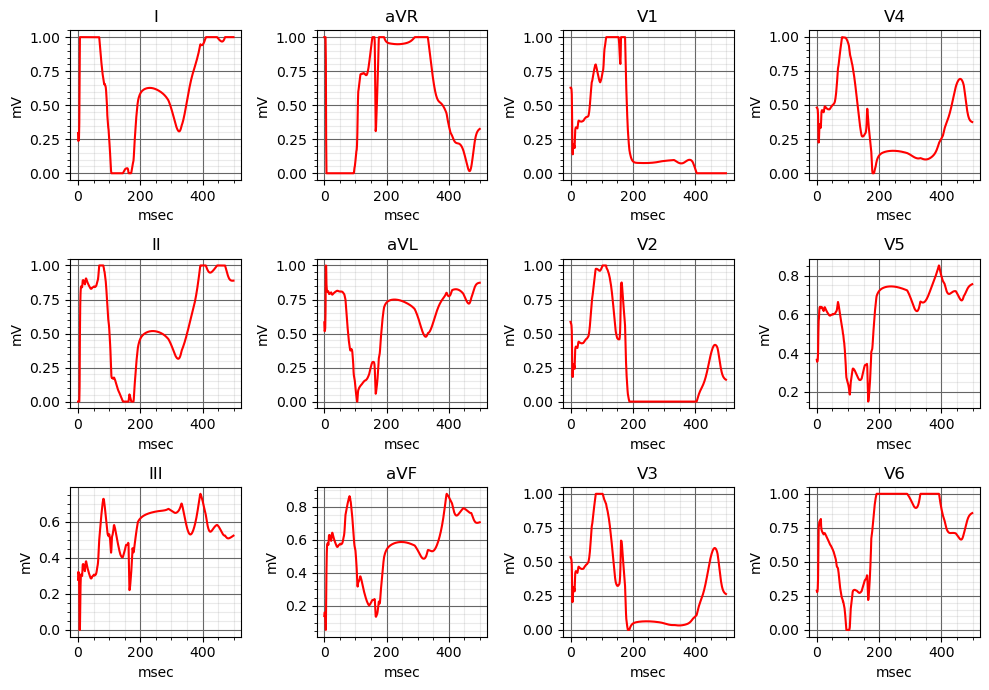

In [7]:
# normalize ECGData
pECGDataNormalized = normalize_ecg(pECGData)
graph_12ecg(pECGDataNormalized, case)

## Combined normalized and original ecg graph

In [ ]:
import matplotlib.pyplot as plt


case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)
pECGDataNormalized = normalize_ecg(pECGData)

width = 25    # 20
height = 6    # 3
lw = 4        # line width, default 2 may want 3
ls = 'dashed' # for the normalized data, linestyle
fs = 35       # font size

originalColor='#005394'
normalizedColor='#c1a961'

plt.rcParams.update({'font.size': fs-5})

fig, (ax1, ax4, ax7, ax10) = plt.subplots(1,4, figsize=(width, height))
fig1, (ax2, ax5, ax8, ax11) = plt.subplots(1,4, figsize=(width, height))
fig2, (ax3, ax6, ax9, ax12) = plt.subplots(1,4, figsize=(width, height))

ax1.plot(pECGData[0:500, 0], label='Original', linewidth=lw, color=originalColor)
ax1.plot(pECGDataNormalized[0:500, 0], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax1.set_title('I', fontsize=fs), ax1.set_xlabel('msec', fontsize=fs), ax1.set_ylabel('mv', fontsize=fs), ax1.grid(visible=True, which='major', color='#666666', linestyle='-'), ax1.minorticks_on()

ax2.plot(pECGData[0:500, 1], label='Original', linewidth=lw, color=originalColor)
ax2.plot(pECGDataNormalized[0:500, 1], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax2.set_title('II', fontsize=fs), ax2.set_xlabel('msec', fontsize=fs), ax2.set_ylabel('mv', fontsize=fs), ax2.grid(visible=True, which='major', color='#666666', linestyle='-'), ax2.minorticks_on()

ax3.plot(pECGData[0:500, 2], label='Original', linewidth=lw, color=originalColor)
ax3.plot(pECGDataNormalized[0:500, 2], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax3.set_title('III', fontsize=fs), ax3.set_xlabel('msec', fontsize=fs), ax3.set_ylabel('mv', fontsize=fs), ax3.grid(visible=True, which='major', color='#666666', linestyle='-'), ax3.minorticks_on()

ax4.plot(pECGData[0:500, 3], label='Original', linewidth=lw, color=originalColor)
ax4.plot(pECGDataNormalized[0:500, 3], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax4.set_title('aVR', fontsize=fs), ax4.set_xlabel('msec', fontsize=fs), ax4.grid(visible=True, which='major', color='#666666', linestyle='-'), ax4.minorticks_on(), ax4.set_ylabel('mv', fontsize=fs)

ax5.plot(pECGData[0:500, 4], label='Original', linewidth=lw, color=originalColor)
ax5.plot(pECGDataNormalized[0:500, 4], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax5.set_title('aVL', fontsize=fs), ax5.set_xlabel('msec', fontsize=fs), ax5.grid(visible=True, which='major', color='#666666', linestyle='-'), ax5.minorticks_on(), ax5.set_ylabel('mv', fontsize=fs)

ax6.plot(pECGData[0:500, 5], label='Original', linewidth=lw, color=originalColor)
ax6.plot(pECGDataNormalized[0:500, 5], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax6.set_title('aVF', fontsize=fs), ax6.set_xlabel('msec', fontsize=fs), ax6.grid(visible=True, which='major', color='#666666', linestyle='-'), ax6.minorticks_on(), ax6.set_ylabel('mv', fontsize=fs)

ax7.plot(pECGData[0:500, 6], label='Original', linewidth=lw, color=originalColor)
ax7.plot(pECGDataNormalized[0:500, 6], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax7.set_title('V1', fontsize=fs), ax7.set_xlabel('msec', fontsize=fs), ax7.grid(visible=True, which='major', color='#666666', linestyle='-'), ax7.minorticks_on(), ax7.set_ylabel('mv', fontsize=fs)

ax8.plot(pECGData[0:500, 7], label='Original', linewidth=lw, color=originalColor)
ax8.plot(pECGDataNormalized[0:500, 7], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax8.set_title('V2', fontsize=fs), ax8.set_xlabel('msec', fontsize=fs), ax8.grid(visible=True, which='major', color='#666666', linestyle='-'), ax8.minorticks_on(), ax8.set_ylabel('mv', fontsize=fs)

ax9.plot(pECGData[0:500, 8], label='Original', linewidth=lw, color=originalColor)
ax9.plot(pECGDataNormalized[0:500, 8], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax9.set_title('V3', fontsize=fs), ax9.set_xlabel('msec', fontsize=fs), ax9.grid(visible=True, which='major', color='#666666', linestyle='-'), ax9.minorticks_on(), ax9.set_ylabel('mv', fontsize=fs)

ax10.plot(pECGData[0:500, 9], label='Original', linewidth=lw, color=originalColor)
ax10.plot(pECGDataNormalized[0:500, 9], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax10.set_title('V4', fontsize=fs), ax10.set_xlabel('msec', fontsize=fs), ax10.grid(visible=True, which='major', color='#666666', linestyle='-'), ax10.minorticks_on(), ax10.set_ylabel('mv', fontsize=fs)

ax11.plot(pECGData[0:500, 10], label='Original', linewidth=lw, color=originalColor)
ax11.plot(pECGDataNormalized[0:500, 10], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax11.set_title('V5', fontsize=fs), ax11.set_xlabel('msec', fontsize=fs), ax11.grid(visible=True, which='major', color='#666666', linestyle='-'), ax11.minorticks_on(), ax11.set_ylabel('mv', fontsize=fs)

ax12.plot(pECGData[0:500, 11], label='Original', linewidth=lw, color=originalColor)
ax12.plot(pECGDataNormalized[0:500, 11], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax12.set_title('V6', fontsize=fs), ax12.set_xlabel('msec', fontsize=fs), ax12.grid(visible=True, which='major', color='#666666', linestyle='-'), ax12.minorticks_on(), ax12.set_ylabel('mv', fontsize=fs)

# plt.legend(fontsize="15")
fig.tight_layout()
fig1.tight_layout()
fig2.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt


case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)
pECGDataNormalized = normalize_ecg(pECGData)

width = 30    # 20
height = 5    # 3
lw = 4        # line width, default 2 may want 3
ls = 'dashed' # for the normalized data, linestyle
fs = 35       # font size

originalColor='#005394'
normalizedColor='#c1a961'

plt.rcParams.update({'font.size': fs})

fig, (ax1, ax4, ax7, ax10) = plt.subplots(1,4, figsize=(width, height))
fig1, (ax2, ax5, ax8, ax11) = plt.subplots(1,4, figsize=(width, height))
fig2, (ax3, ax6, ax9, ax12) = plt.subplots(1,4, figsize=(width, height))

ax1.plot(pECGData[0:500, 0], label='Original', linewidth=lw, color=originalColor)
ax1.plot(pECGDataNormalized[0:500, 0], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax1.set_title('I', fontsize=fs), ax1.set_ylabel('mv', fontsize=fs), ax1.grid(visible=True, which='major', color='#666666', linestyle='-'), ax1.minorticks_on()

ax2.plot(pECGData[0:500, 1], label='Original', linewidth=lw, color=originalColor)
ax2.plot(pECGDataNormalized[0:500, 1], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax2.set_title('II', fontsize=fs), ax2.set_ylabel('mv', fontsize=fs), ax2.grid(visible=True, which='major', color='#666666', linestyle='-'), ax2.minorticks_on()

ax3.plot(pECGData[0:500, 2], label='Original', linewidth=lw, color=originalColor)
ax3.plot(pECGDataNormalized[0:500, 2], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax3.set_title('III', fontsize=fs), ax3.set_xlabel('msec', fontsize=fs), ax3.set_ylabel('mv', fontsize=fs), ax3.grid(visible=True, which='major', color='#666666', linestyle='-'), ax3.minorticks_on()

ax4.plot(pECGData[0:500, 3], label='Original', linewidth=lw, color=originalColor)
ax4.plot(pECGDataNormalized[0:500, 3], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax4.set_title('aVR', fontsize=fs), ax4.grid(visible=True, which='major', color='#666666', linestyle='-'), ax4.minorticks_on()

ax5.plot(pECGData[0:500, 4], label='Original', linewidth=lw, color=originalColor)
ax5.plot(pECGDataNormalized[0:500, 4], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax5.set_title('aVL', fontsize=fs), ax5.grid(visible=True, which='major', color='#666666', linestyle='-'), ax5.minorticks_on()

ax6.plot(pECGData[0:500, 5], label='Original', linewidth=lw, color=originalColor)
ax6.plot(pECGDataNormalized[0:500, 5], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax6.set_title('aVF', fontsize=fs), ax6.set_xlabel('msec', fontsize=fs), ax6.grid(visible=True, which='major', color='#666666', linestyle='-'), ax6.minorticks_on()

ax7.plot(pECGData[0:500, 6], label='Original', linewidth=lw, color=originalColor)
ax7.plot(pECGDataNormalized[0:500, 6], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax7.set_title('V1', fontsize=fs), ax7.grid(visible=True, which='major', color='#666666', linestyle='-'), ax7.minorticks_on()

ax8.plot(pECGData[0:500, 7], label='Original', linewidth=lw, color=originalColor)
ax8.plot(pECGDataNormalized[0:500, 7], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax8.set_title('V2', fontsize=fs), ax8.grid(visible=True, which='major', color='#666666', linestyle='-'), ax8.minorticks_on()

ax9.plot(pECGData[0:500, 8], label='Original', linewidth=lw, color=originalColor)
ax9.plot(pECGDataNormalized[0:500, 8], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax9.set_title('V3', fontsize=fs), ax9.set_xlabel('msec', fontsize=fs), ax9.grid(visible=True, which='major', color='#666666', linestyle='-'), ax9.minorticks_on()

ax10.plot(pECGData[0:500, 9], label='Original', linewidth=lw, color=originalColor)
ax10.plot(pECGDataNormalized[0:500, 9], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax10.set_title('V4', fontsize=fs), ax10.grid(visible=True, which='major', color='#666666', linestyle='-'), ax10.minorticks_on()

ax11.plot(pECGData[0:500, 10], label='Original', linewidth=lw, color=originalColor)
ax11.plot(pECGDataNormalized[0:500, 10], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax11.set_title('V5', fontsize=fs), ax11.grid(visible=True, which='major', color='#666666', linestyle='-'), ax11.minorticks_on()

ax12.plot(pECGData[0:500, 11], label='Original', linewidth=lw, color=originalColor)
ax12.plot(pECGDataNormalized[0:500, 11], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax12.set_title('V6', fontsize=fs), ax12.set_xlabel('msec', fontsize=fs), ax12.grid(visible=True, which='major', color='#666666', linestyle='-'), ax12.minorticks_on()

# plt.legend(fontsize='25')
fig.tight_layout(pad=0.2)
fig1.tight_layout(pad=0.2)
fig2.tight_layout(pad=0.2)
plt.show()

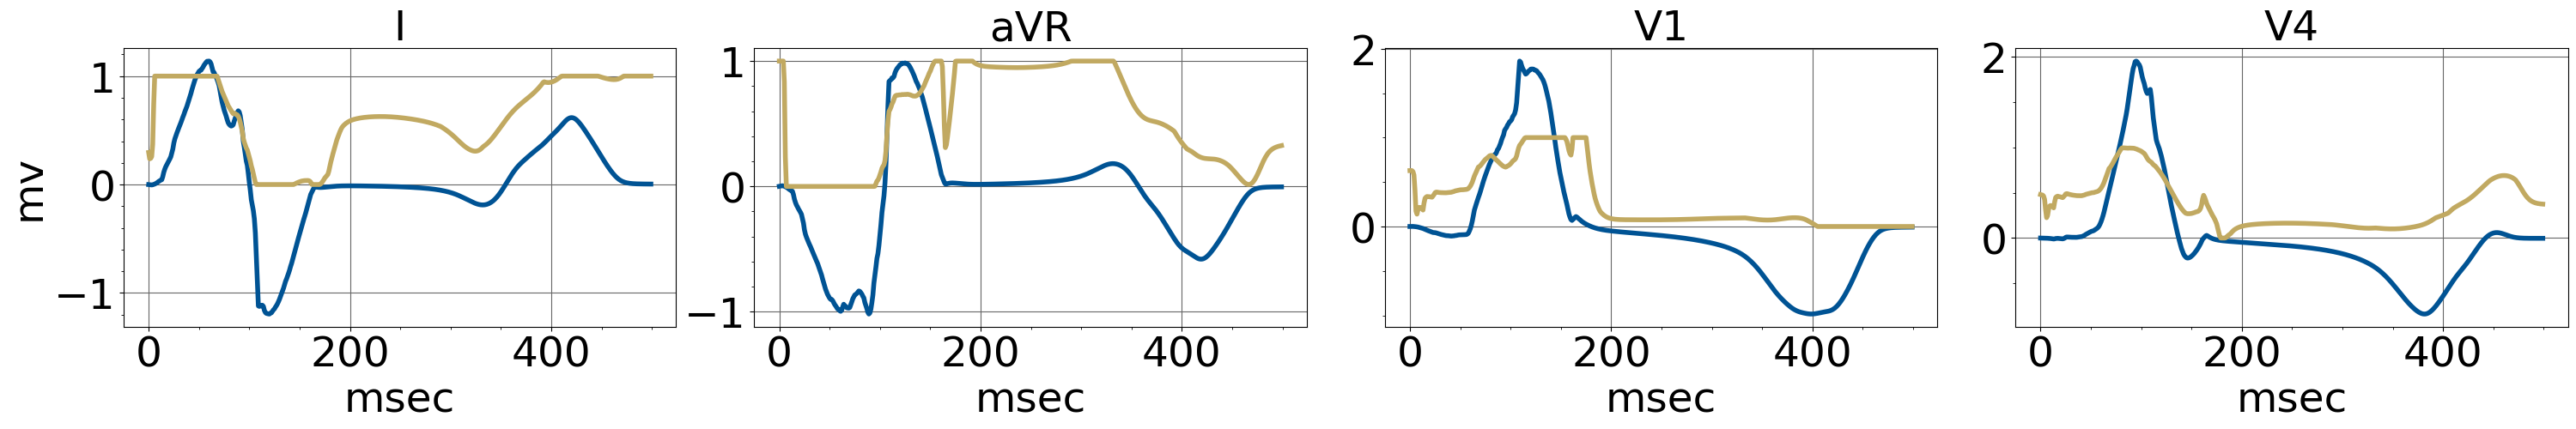

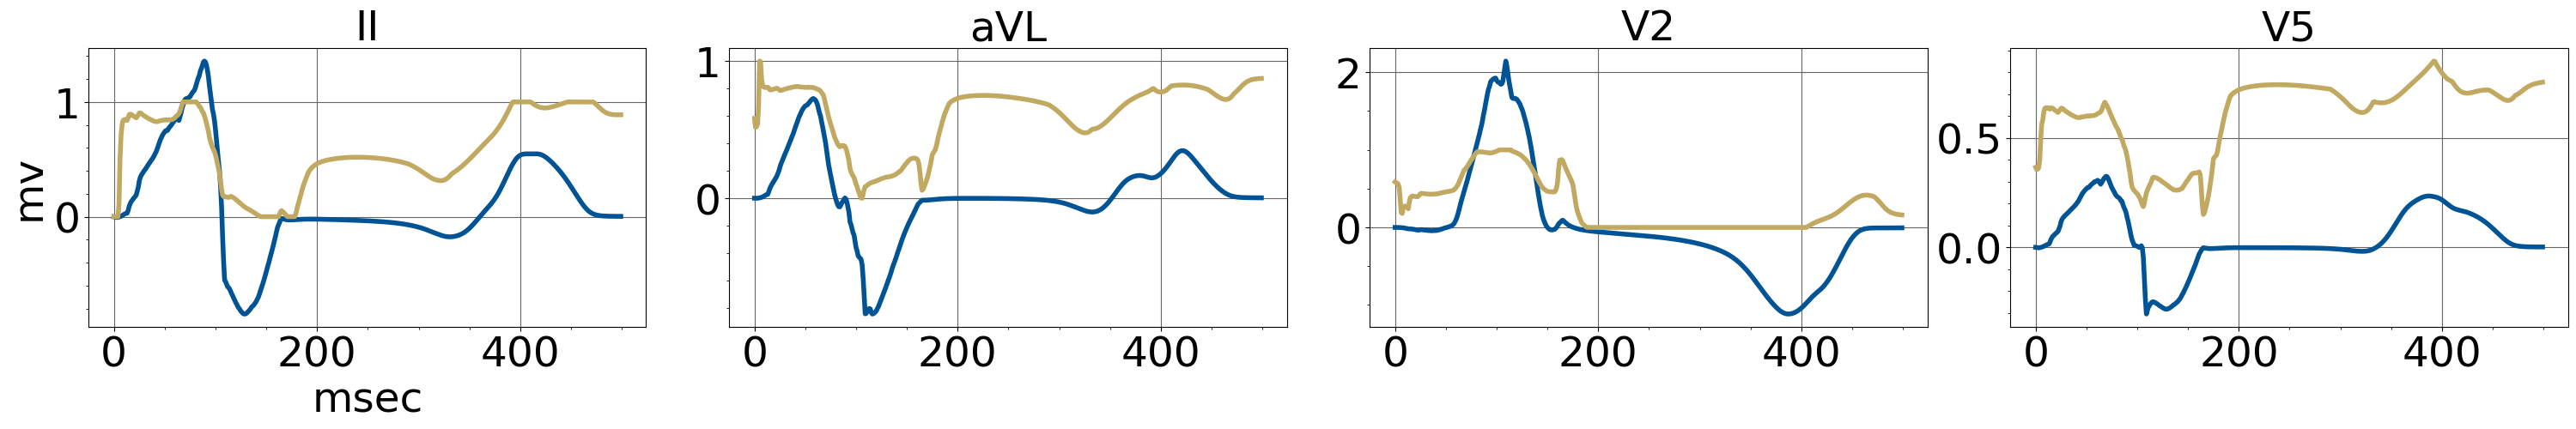

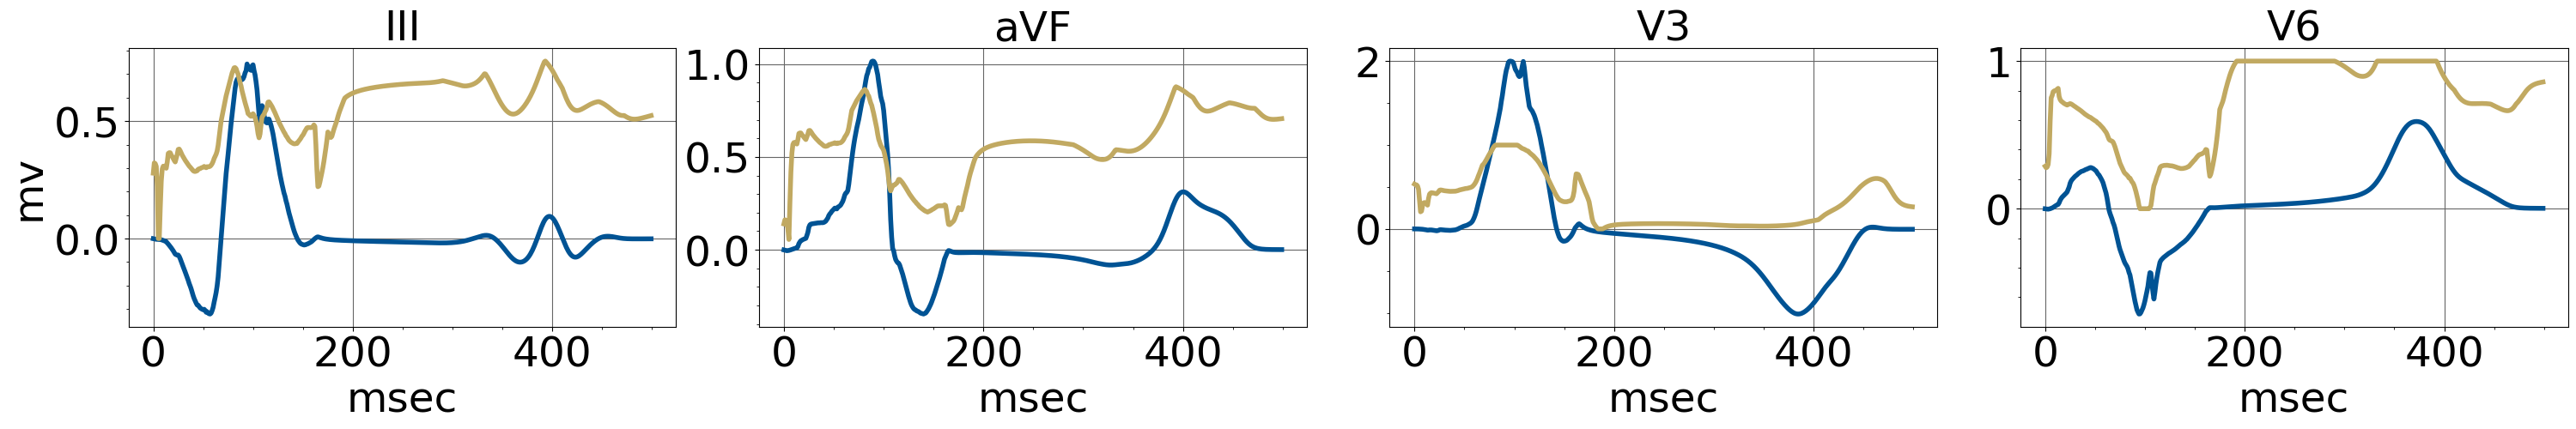

In [19]:
import matplotlib.pyplot as plt


case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)
pECGDataNormalized = normalize_ecg(pECGData)

width = 30    # 20
height = 5    # 3
lw = 4        # line width, default 2 may want 3
ls = 'solid' # for the normalized data, linestyle
fs = 35       # font size

originalColor='#005394'
normalizedColor='#c1a961'

plt.rcParams.update({'font.size': fs})

fig, (ax1, ax4, ax7, ax10) = plt.subplots(1,4, figsize=(width, height))
fig1, (ax2, ax5, ax8, ax11) = plt.subplots(1,4, figsize=(width, height))
fig2, (ax3, ax6, ax9, ax12) = plt.subplots(1,4, figsize=(width, height))

ax1.plot(pECGData[0:500, 0], label='Original', linewidth=lw, color=originalColor)
ax1.plot(pECGDataNormalized[0:500, 0], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax1.set_title('I', fontsize=fs), ax1.set_xlabel('msec', fontsize=fs), ax1.set_ylabel('mv', fontsize=fs), ax1.grid(visible=True, which='major', color='#666666', linestyle='-'), ax1.minorticks_on()

ax2.plot(pECGData[0:500, 1], label='Original', linewidth=lw, color=originalColor)
ax2.plot(pECGDataNormalized[0:500, 1], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax2.set_title('II', fontsize=fs), ax2.set_xlabel('msec', fontsize=fs), ax2.set_ylabel('mv', fontsize=fs), ax2.grid(visible=True, which='major', color='#666666', linestyle='-'), ax2.minorticks_on()

ax3.plot(pECGData[0:500, 2], label='Original', linewidth=lw, color=originalColor)
ax3.plot(pECGDataNormalized[0:500, 2], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax3.set_title('III', fontsize=fs), ax3.set_xlabel('msec', fontsize=fs), ax3.set_ylabel('mv', fontsize=fs), ax3.grid(visible=True, which='major', color='#666666', linestyle='-'), ax3.minorticks_on()

ax4.plot(pECGData[0:500, 3], label='Original', linewidth=lw, color=originalColor)
ax4.plot(pECGDataNormalized[0:500, 3], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax4.set_title('aVR', fontsize=fs), ax4.set_xlabel('msec', fontsize=fs), ax4.grid(visible=True, which='major', color='#666666', linestyle='-'), ax4.minorticks_on()

ax5.plot(pECGData[0:500, 4], label='Original', linewidth=lw, color=originalColor)
ax5.plot(pECGDataNormalized[0:500, 4], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax5.set_title('aVL', fontsize=fs), ax5.grid(visible=True, which='major', color='#666666', linestyle='-'), ax5.minorticks_on()

ax6.plot(pECGData[0:500, 5], label='Original', linewidth=lw, color=originalColor)
ax6.plot(pECGDataNormalized[0:500, 5], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax6.set_title('aVF', fontsize=fs), ax6.set_xlabel('msec', fontsize=fs), ax6.grid(visible=True, which='major', color='#666666', linestyle='-'), ax6.minorticks_on()

ax7.plot(pECGData[0:500, 6], label='Original', linewidth=lw, color=originalColor)
ax7.plot(pECGDataNormalized[0:500, 6], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax7.set_title('V1', fontsize=fs), ax7.set_xlabel('msec', fontsize=fs), ax7.grid(visible=True, which='major', color='#666666', linestyle='-'), ax7.minorticks_on()

ax8.plot(pECGData[0:500, 7], label='Original', linewidth=lw, color=originalColor)
ax8.plot(pECGDataNormalized[0:500, 7], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax8.set_title('V2', fontsize=fs), ax8.grid(visible=True, which='major', color='#666666', linestyle='-'), ax8.minorticks_on()

ax9.plot(pECGData[0:500, 8], label='Original', linewidth=lw, color=originalColor)
ax9.plot(pECGDataNormalized[0:500, 8], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax9.set_title('V3', fontsize=fs), ax9.set_xlabel('msec', fontsize=fs), ax9.grid(visible=True, which='major', color='#666666', linestyle='-'), ax9.minorticks_on()

ax10.plot(pECGData[0:500, 9], label='Original', linewidth=lw, color=originalColor)
ax10.plot(pECGDataNormalized[0:500, 9], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax10.set_title('V4', fontsize=fs), ax10.set_xlabel('msec', fontsize=fs), ax10.grid(visible=True, which='major', color='#666666', linestyle='-'), ax10.minorticks_on()

ax11.plot(pECGData[0:500, 10], label='Original', linewidth=lw, color=originalColor)
ax11.plot(pECGDataNormalized[0:500, 10], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax11.set_title('V5', fontsize=fs), ax11.grid(visible=True, which='major', color='#666666', linestyle='-'), ax11.minorticks_on()

ax12.plot(pECGData[0:500, 11], label='Original', linewidth=lw, color=originalColor)
ax12.plot(pECGDataNormalized[0:500, 11], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax12.set_title('V6', fontsize=fs), ax12.set_xlabel('msec', fontsize=fs), ax12.grid(visible=True, which='major', color='#666666', linestyle='-'), ax12.minorticks_on()

# plt.legend(fontsize='25')
fig.tight_layout(pad=0.2)
fig1.tight_layout(pad=0.2)
fig2.tight_layout(pad=0.2)
plt.show()

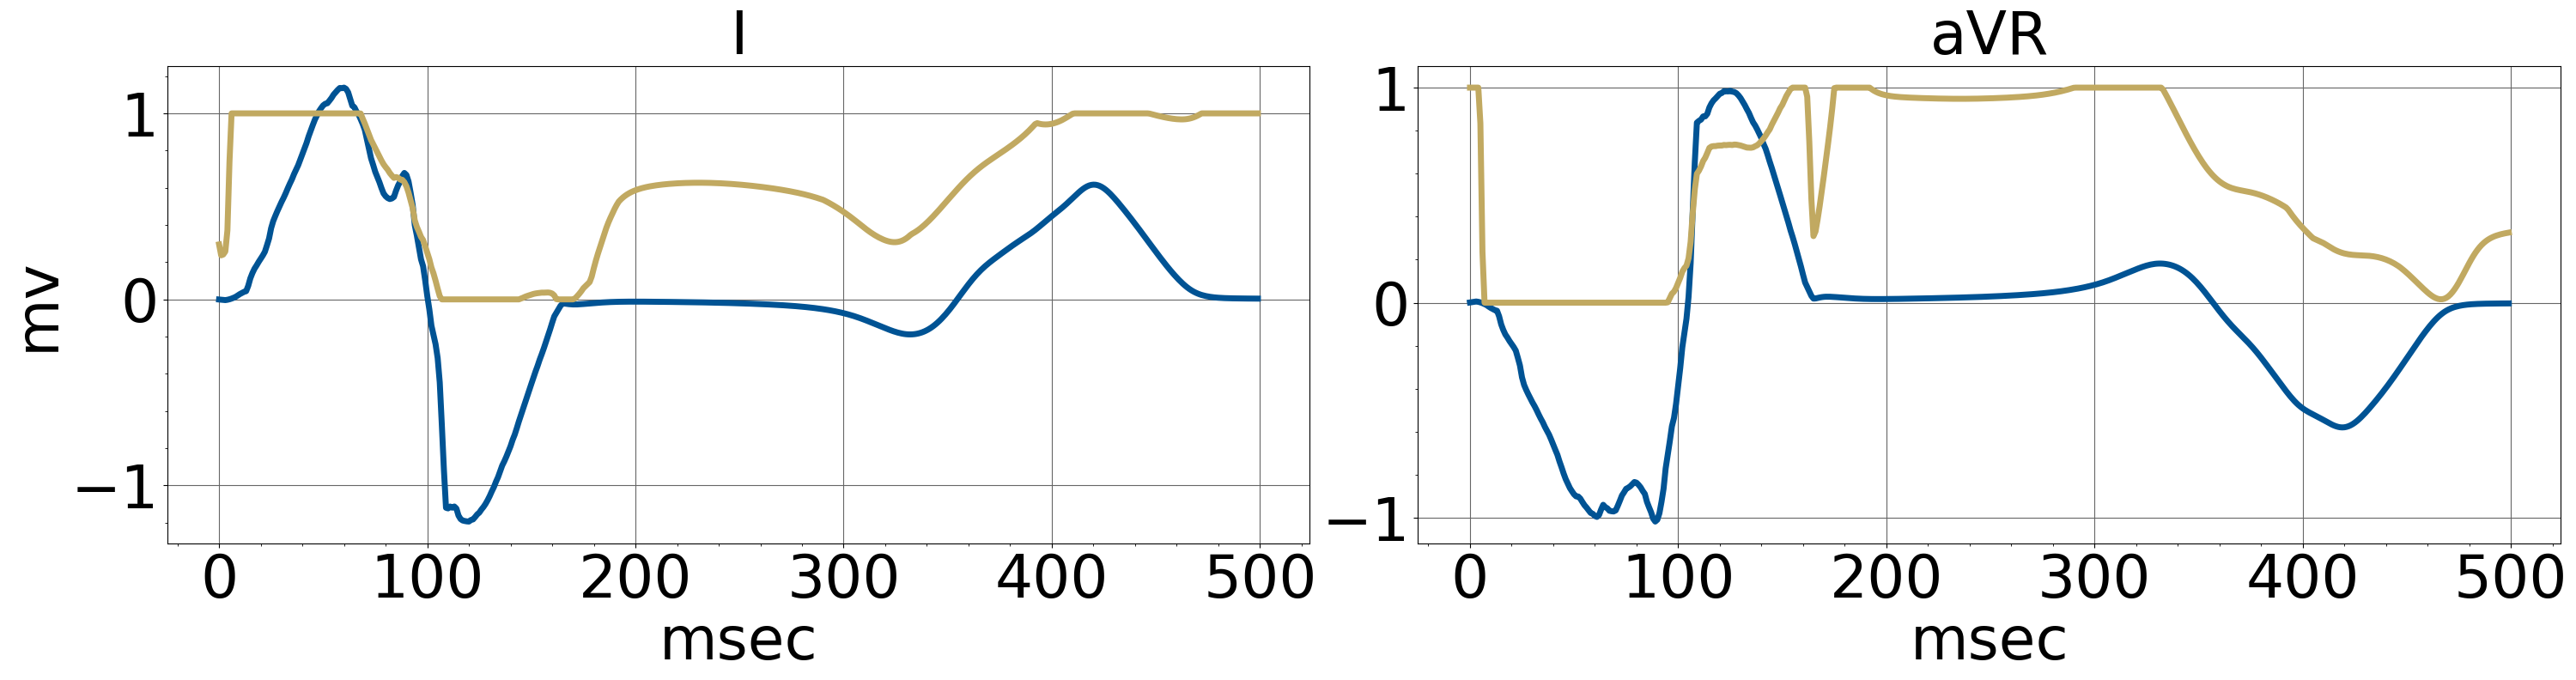

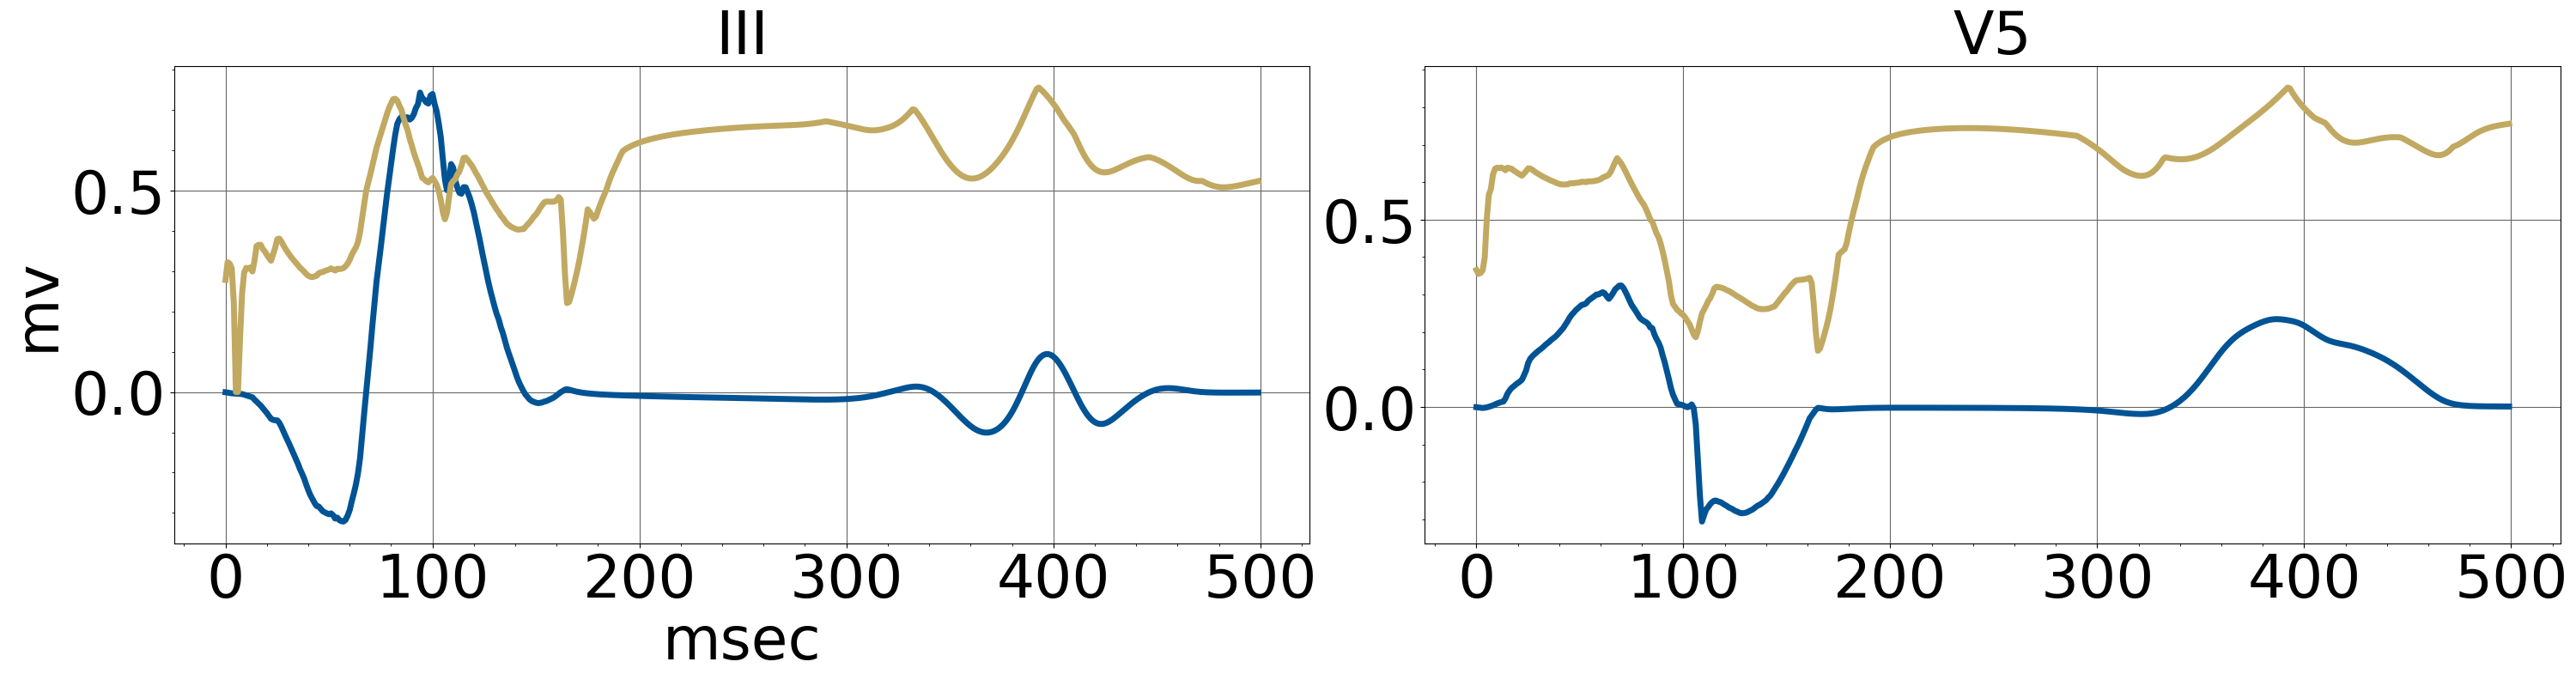

In [18]:
import matplotlib.pyplot as plt


case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)
pECGDataNormalized = normalize_ecg(pECGData)

width = 30    # 20
height = 8    # 3
lw = 5        # line width, default 2 may want 3
ls = 'solid' # for the normalized data, linestyle
fs = 50       # font size

originalColor='#005394'
normalizedColor='#c1a961'

plt.rcParams.update({'font.size': fs})

fig, (ax1, ax4) = plt.subplots(1,2, figsize=(width, height))
fig1, (ax3, ax11) = plt.subplots(1,2, figsize=(width, height))

ax1.plot(pECGData[0:500, 0], label='Original', linewidth=lw, color=originalColor)
ax1.plot(pECGDataNormalized[0:500, 0], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax1.set_title('I', fontsize=fs), ax1.set_xlabel('msec', fontsize=fs), ax1.set_ylabel('mv', fontsize=fs), ax1.grid(visible=True, which='major', color='#666666', linestyle='-'), ax1.minorticks_on()

ax2.plot(pECGData[0:500, 1], label='Original', linewidth=lw, color=originalColor)
ax2.plot(pECGDataNormalized[0:500, 1], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax2.set_title('II', fontsize=fs), ax2.set_xlabel('msec', fontsize=fs), ax2.set_ylabel('mv', fontsize=fs), ax2.grid(visible=True, which='major', color='#666666', linestyle='-'), ax2.minorticks_on()

ax3.plot(pECGData[0:500, 2], label='Original', linewidth=lw, color=originalColor)
ax3.plot(pECGDataNormalized[0:500, 2], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax3.set_title('III', fontsize=fs), ax3.set_xlabel('msec', fontsize=fs), ax3.set_ylabel('mv', fontsize=fs), ax3.grid(visible=True, which='major', color='#666666', linestyle='-'), ax3.minorticks_on()

ax4.plot(pECGData[0:500, 3], label='Original', linewidth=lw, color=originalColor)
ax4.plot(pECGDataNormalized[0:500, 3], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax4.set_title('aVR', fontsize=fs), ax4.set_xlabel('msec', fontsize=fs), ax4.grid(visible=True, which='major', color='#666666', linestyle='-'), ax4.minorticks_on()

ax5.plot(pECGData[0:500, 4], label='Original', linewidth=lw, color=originalColor)
ax5.plot(pECGDataNormalized[0:500, 4], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax5.set_title('aVL', fontsize=fs), ax5.grid(visible=True, which='major', color='#666666', linestyle='-'), ax5.minorticks_on()

ax6.plot(pECGData[0:500, 5], label='Original', linewidth=lw, color=originalColor)
ax6.plot(pECGDataNormalized[0:500, 5], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax6.set_title('aVF', fontsize=fs), ax6.set_xlabel('msec', fontsize=fs), ax6.grid(visible=True, which='major', color='#666666', linestyle='-'), ax6.minorticks_on()

ax7.plot(pECGData[0:500, 6], label='Original', linewidth=lw, color=originalColor)
ax7.plot(pECGDataNormalized[0:500, 6], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax7.set_title('V1', fontsize=fs), ax7.set_xlabel('msec', fontsize=fs), ax7.grid(visible=True, which='major', color='#666666', linestyle='-'), ax7.minorticks_on()

ax8.plot(pECGData[0:500, 7], label='Original', linewidth=lw, color=originalColor)
ax8.plot(pECGDataNormalized[0:500, 7], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax8.set_title('V2', fontsize=fs), ax8.grid(visible=True, which='major', color='#666666', linestyle='-'), ax8.minorticks_on()

ax9.plot(pECGData[0:500, 8], label='Original', linewidth=lw, color=originalColor)
ax9.plot(pECGDataNormalized[0:500, 8], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax9.set_title('V3', fontsize=fs), ax9.set_xlabel('msec', fontsize=fs), ax9.grid(visible=True, which='major', color='#666666', linestyle='-'), ax9.minorticks_on()

ax10.plot(pECGData[0:500, 9], label='Original', linewidth=lw, color=originalColor)
ax10.plot(pECGDataNormalized[0:500, 9], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax10.set_title('V4', fontsize=fs), ax10.set_xlabel('msec', fontsize=fs), ax10.grid(visible=True, which='major', color='#666666', linestyle='-'), ax10.minorticks_on()

ax11.plot(pECGData[0:500, 10], label='Original', linewidth=lw, color=originalColor)
ax11.plot(pECGDataNormalized[0:500, 10], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax11.set_title('V5', fontsize=fs), ax11.grid(visible=True, which='major', color='#666666', linestyle='-'), ax11.minorticks_on()

ax12.plot(pECGData[0:500, 11], label='Original', linewidth=lw, color=originalColor)
ax12.plot(pECGDataNormalized[0:500, 11], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax12.set_title('V6', fontsize=fs), ax12.set_xlabel('msec', fontsize=fs), ax12.grid(visible=True, which='major', color='#666666', linestyle='-'), ax12.minorticks_on()

# plt.legend(fontsize='25')
fig.tight_layout(pad=0.2)
fig1.tight_layout(pad=0.2)
fig2.tight_layout(pad=0.2)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

case = 8275
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)
pECGDataNormalized = normalize_ecg(pECGData)

width = 10    # 20
height = 10    # 3
lw = 18        # default 2 may want 3
ls = 'solid' # for the normalized data, linestyle

originalColor='#005394'
normalizedColor='#c1a961'

fig, (ax1) = plt.subplots(1,1, figsize=(width, height))

# ax1.plot(pECGData[0:500, 0], label='Original', linewidth=lw, color=originalColor)
# ax1.plot(pECGDataNormalized[0:500, 0], label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)
ax1.plot(1,1, label='Original', linewidth=lw, color=originalColor)
ax1.plot(0,0, label='Normalized', linestyle=ls, linewidth=lw, color=normalizedColor)

ax1.set_title('I'), ax1.set_xlabel('msec'), ax1.set_ylabel('mv')

plt.legend(fontsize=80, prop={'weight':'bold'})
plt.show()

## Vm Data graphing

In [ ]:
# Example of file pair
# Vm plot
def graphVmData(data, case, row=7, column=10):
    num_timesteps = 500
    plt.figure(figsize=(18, 9))
    
    print('Case {} : {}'.format(case, file_pairs[case][0]))
    
    for count, i in enumerate(range(data.shape[1])):
        plt.subplot(8, 10, count + 1)
        plt.plot(data[0:num_timesteps,i])
        plt.title(f'i = {i}')
        plt.grid(visible=True, which='major', color='#666666', linestyle='-')
        plt.minorticks_on()
        plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        # plt.xlabel('msec')
        # plt.ylabel('mV')
    plt.tight_layout()
    plt.show()
    # close
    plt.close()

In [29]:
def averageData(data, case):
    print(f'Case: {case}')
    average = 0
    for point in data:
        average += point
        # print(f'Point: {point}')
    
    return average/500

## Regular VmData graph

In [ ]:
VmData = np.load(file_pairs[case][1])

averageData(VmData, 872)

## Normalized VmData graphs

In [ ]:
VmDataNormalized = normalize_ecg(VmData)
graphVmData(VmDataNormalized, 872)

## Zoomed out normalized VmData

In [ ]:
# Example of file pair

# case = 10743
# # Vm plot
# row = 7
# column = 10
plt.figure(figsize=(18, 9))

plt.plot(VmDataNormalized[0:num_timesteps,0])
plt.title(f'i = {1}')
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
# plt.xlabel('msec')
# plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

## Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

In [ ]:
# Example of file pair
# case = 10743
plt.figure(figsize=(1, 10))

for case in range(len(file_pairs)):
    plt.figure(figsize=(1, 10))
    print('Case {} : {}'.format(case, file_pairs[case][0]))
    VmData = np.load(file_pairs[case][1])
    
    ActTime = get_activation_time(VmData)
    
    print(ActTime.shape)
    
    # plot the Activation Time array
    plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
    plt.title('Activation Time')
    plt.colorbar()
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    # not xticks
    plt.xticks([])
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.show()


## Task 3: Learning the mapping from the 12-lead ECG to the activation map

In [ ]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

def averageOf(times):
    sum = 0
    for time in times:
        sum += time
        
    return (sum/len(times))

# print('Case {} : {}'.format(j, file_pairs[j][0]))
# pECGData = np.load(file_pairs[case][0])
# pECGData = get_standard_leads(pECGData)

# print('Case {} : {}'.format(j, file_pairs[j][1]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# print(f'Average activation time for case {j}: {averageOf(ActTime)}')

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 2
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
# plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off') # remove the plot from the arrow
# plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(pECGDataNormalized.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGDataNormalized')
plt.show()
plt.close()


# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.